# Mapping urban poverty using machine learning

### Objective:
The overall objective is develop a reproducible, semi-automated aprroach to map urban poverty in Accra, Ghana. This model aims to detect poverty locations to assist urban planing and management. 

### methodology
Remote sensing-based method is used to capture the location and morphological charactersitics of deprived area (slums). The hihg variability in appearance of slums makes it possible to map them. In addition to the remote sensing data, we added GIS data wich serves as proxy ofr socioeconomic variables to map poverty. The dataset includes freely available Sentinel 2 (10m resolution) and socioeconomic data from OpenStreetMap.

#### Datasets 
 | Data | Rationale | Source |
 | :-: | :-: | :-:| 
 | Sentinel-2 | Freely avaible at a global scale  | Sentinel Hub |
 | Industries | Slums are often located closed to industrial site | OpenStreetMap
 | Major roads |Slums are located close to major roads | OpenStreetMap |
 | Market |Slums are located closed to market | OpenStreetMap |



 # Part 1: Collecting data
 
 1. Sentinel 1 and NDVI was downloaded from sentinel Hub (https://apps.sentinel-hub.com/eo-browser/)
 
 2. OpenStreetMap data was collecting using the Ohsome API (https://docs.ohsome.org/ohsome-api/v1/)
 
The code belows shows the steps to obtain OSM data  

In [2]:
# Import libraries 
!pip install distancerasters
!pip install seaborn
!pip install contextily
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import fiona
import distancerasters as dr
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import contextily as ctx

In [3]:
# load AOI
with open(r'./Data/AmaBoundary.geojson') as inf:
    regions_dict = json.load(inf)

# Getting Market, Industry, Highway Geojson

In [4]:
# create output folder
! mkdir output -p 

# download market 

URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {
    "bpolys": json.dumps(regions_dict),
    "time": "2022-01-01",
    "filter": "amenity=marketplace"
}
response = requests.post(URL, data=data)
display(response)

# download data
output = "./output/market.geojson"
with open(output, "w") as f:
    json.dump(response.json(), f)

<Response [200]>

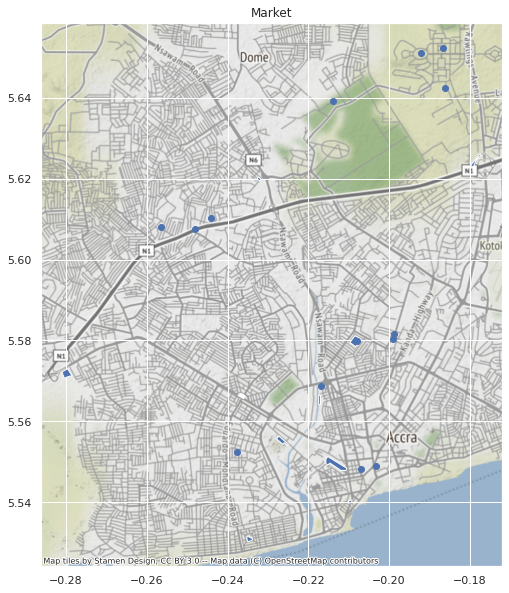

In [5]:
# Visualise market location
fp = './output/market.geojson'
df = gpd.read_file(fp)
fig, axes = plt.subplots(figsize=(10, 10), sharey=True, sharex=True)

df.plot(ax=axes).set_title('Market')
ctx.add_basemap(ax=axes, crs=df.crs)

In [6]:
# download highway

URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {
    "bpolys": json.dumps(regions_dict),
    "time": "2022-01-01",
    "filter": "highway=primary or highway=secondary"
}
response = requests.post(URL, data=data)
display(response)

# download data
output = "./output/highway.geojson"
with open(output, "w") as f:
    json.dump(response.json(), f)

<Response [200]>

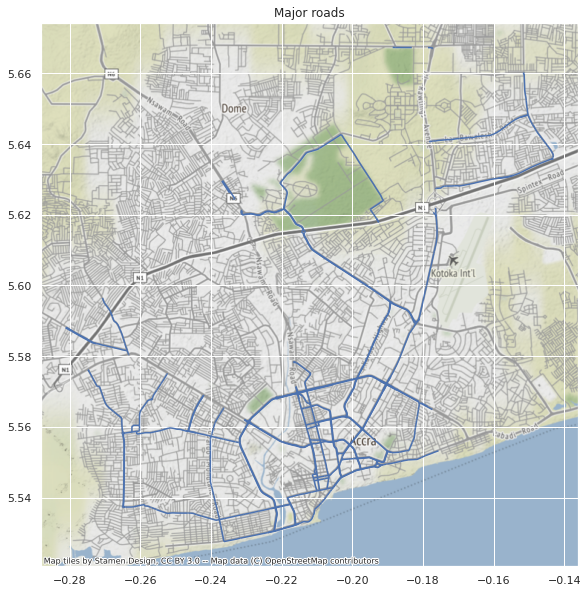

In [7]:
# Visualisse major roads location
fp = './output/highway.geojson'
df = gpd.read_file(fp)
fig, axes = plt.subplots(figsize=(10, 10), sharey=True, sharex=True)

df.plot(ax=axes).set_title('Major roads')
ctx.add_basemap(ax=axes, crs=df.crs)

In [8]:
# download industry 

URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {
    "bpolys": json.dumps(regions_dict),
    "time": "2022-01-01",
    "filter": "landuse = industrial"
}
response = requests.post(URL, data=data)
display(response)

# download data
output = "./output/industry.geojson"
with open(output, "w") as f:
    json.dump(response.json(), f)

<Response [200]>

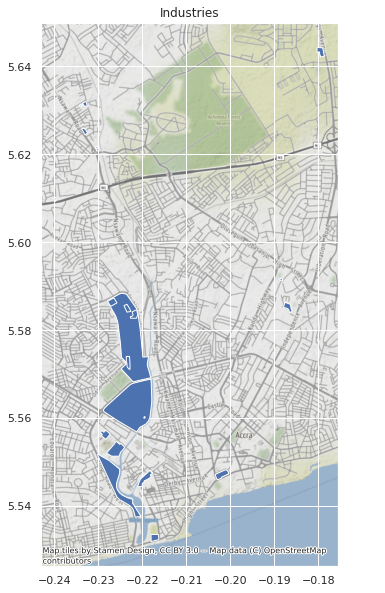

In [9]:
# Visualisse industries location
fp = './output/industry.geojson'
df = gpd.read_file(fp)
fig, axes = plt.subplots(figsize=(10, 10), sharey=True, sharex=True)

df.plot(ax=axes).set_title('Industries')
ctx.add_basemap(ax=axes, crs=df.crs)

# GIS data parameterization 


 | Data | Rationale | parameterization |
 | :-: | :-: | :-:| 
 | Industries | Slums are often located closed to industrial site | Association- distance to industry
 | Major roads |Slums are located close to major roads | Association - distance from majot roads
 | Market |Slums are located closed to market |Association - distance to market


# Computing Euclidean Distance

In [10]:
!pip install fiona

In [11]:
import rasterio 

from glob import glob

filelist = sorted(glob("./output/*.geojson"))
print(filelist)
#filelist = ['./output/market.geojson','./output/highway.geojson','./output/industry.geojson']
# load AOI
AOI = fiona.open(r'./Data/AmaBoundary.geojson') 

['./output/ETH_ppt_2010.geojson', './output/ETH_ppt_20102.geojson', './output/ET_webmerc.geojson', './output/TRIAL_ETH_ppt_2010.geojson', './output/highway.geojson', './output/industry.geojson', './output/market.geojson', './output/train_set_points.geojson']


In [12]:
filelist = ['./output/market.geojson','./output/highway.geojson','./output/industry.geojson']

In [13]:
# setting outfile name
filename = []
    # loop from input 
for file in filelist:
    head, tail = os.path.split(file)
    col_names=tail[:-8]
    filename.append(col_names)
print(filename)

['market', 'highway', 'industry']


# Compute euclidean distance for  Market, Highway, and Industry 

In [17]:
n = 0
for file in filelist:
    print(f'/Data/img/{filename[n]}.tiff')
    n += 1

/Data/img/market.tiff
/Data/img/highway.tiff
/Data/img/industry.tiff


In [19]:

# import image 
acc_image  = rasterio.open ('./Data/img/B02.tiff')
pixel_size = acc_image.res[0]

n = 0
for file in filelist:
    shp = fiona.open(file, "r")

    # create binary raster and affine
    rv_array, affine = dr.rasterize(shp, 
                                    pixel_size=pixel_size, 
                                    bounds=AOI.bounds)

    # generate distance array and output to geotiff
    my_dr = dr.DistanceRaster(rv_array, 
                              affine=affine,
                              output_path=f"./Data/img/{filename[n]}.tiff")
    n += 1

Tree build time: 0.0097 seconds
Distance calc run time: 174.3059 seconds
Tree build time: 0.0131 seconds
Distance calc run time: 174.5549 seconds
Tree build time: 0.0164 seconds
Distance calc run time: 183.9904 seconds


# Compute NDVI

In [20]:
band_list = ['./Data/img/B04.tiff', './Data/img/B08.tiff']
out_file = './Data/img/ndvi.tiff'

def NDVI(band_list,out_file):
    '''Returns NDVI'''


    with rasterio.open(band_list[0], mode="r") as src_red:
        red = src_red.read(1) 
        red = red.astype(np.float32)
    with rasterio.open(band_list[1], mode="r") as src_nir:
        nir = src_nir.read(1) 
        nir = nir.astype(np.float32)
    
    # treatment for division by zero
    np.seterr(divide = 'ignore', invalid = 'ignore')
    
    # calculate NDVI
    ndvi = (nir - red)/ (nir + red)
    
    # update profile from red band
    with rasterio.open(band_list[0], mode="r") as src_red:
        out_profile = src_red.profile.copy()
        out_profile.update(count=1,
                           nodata = -9999,
                           dtype='float32',
                          width=src_red.width,
                          height = src_red.height,
                          crs = src_red.crs)
    
    # open in 'write' mode, unpack profile info to dst
    with rasterio.open(out_file, 
                      'w', **out_profile) as dst:
        dst.write_band(1, ndvi)
    
    return ndvi

# execute the function
NDVI(band_list,out_file)

# read the data back in 
ndvi_array = rasterio.open(out_file).read()